<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/AAA/datasetNuevo_EntLink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Librerías

In [1]:
import numpy as np
import os,shutil,json
import xml.etree.ElementTree as ET
from pathlib import Path
import glob
import operator
import sys
import argparse
import math
from matplotlib import pyplot as plt
import cv2
import json
import re
from imutils.contours import sort_contours
import imutils
import statistics as stats
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def mostrarImagen(imagePath):
  image = cv2.imread(imagePath)
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(20,15))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(20,15))
    plt.imshow(img2,cmap='gray')
    plt.show()

def Imagen(image):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(20,15))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(20,15))
    plt.imshow(img2,cmap='gray')
    plt.show()

In [3]:
! pip uninstall googletrans
! pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 11.3 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=8eeb721ba1994eecfebf37fb58385a4fd9d5f2cb88fd28db25acb21f2ba62399
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [4]:
from googletrans import Translator

# Predicción bloques de texto

### Darknet

In [5]:
%%capture
!git clone https://github.com/AlexeyAB/darknet

In [6]:
%%capture
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [7]:
%%capture
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [8]:
%%capture
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

In [9]:
%%capture
!apt-get install tree

### Librerías y funciones

In [10]:
def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return ([xmin,ymin, xmax,  ymax])

In [11]:
def non_max_suppression_fast(boxes, overlapThresh=0.3):
  if len(boxes) == 0:
    return []
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  pick = []
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  area=(x2-x1)*(y2-y1)
  idxs = np.argsort(area)
  while len(idxs) > 0:
      i = idxs[0]
      xx1=x1[i]
      xx2=x2[i]
      yy1=y1[i]
      yy2=y2[i]
      x=xx2-xx1
      y=yy2-yy1
      aniadirBbox=True
      for k in idxs[1:]:
        if x1[k]<=xx1+overlapThresh*x and x2[k]>=xx2-overlapThresh*x and y1[k]<=yy1+overlapThresh*y and y2[k]>=yy2-overlapThresh*y:
          aniadirBbox=False
      if aniadirBbox:
        pick.append(i)
      idxs = np.delete(idxs, 0)
  return boxes[pick].astype("int")

In [12]:
def abrirImagen(path):
  return cv2.imread(str(path))

## Descarga de archivos

In [13]:
%%capture
!wget https://www.dropbox.com/s/wxzrfb5wtdgdgi8/funsd_last.weights?dl=0 -O funsd_last.weights
!wget https://www.dropbox.com/s/2hdgc14avqle31s/funsd.cfg?dl=0 -O funsd.cfg
!wget https://www.dropbox.com/s/eaf1sp3k1xoig7h/funsd.data?dl=0 -O funsd.data
!wget https://www.dropbox.com/s/vwxyeohq1amz369/funsd.names?dl=0 -O funsd.names

In [14]:
%%capture
!unzip /content/Facturas.zip

In [15]:
path='Facturas'
files = [Path(str(path)+'/'+p) for p in os.listdir(path) if p[-1]=='g']

In [16]:
txt=open('test.txt','w')
for f in files:
  txt.write(str(f)+'\n')
txt.close() 

In [17]:
txt=open('classes.data','w')
txt.write('classes = 4\n')
txt.write('train  = train.txt\n')
txt.write('valid  = test.txt\n')
txt.write('names = funsd.names\n')
txt.write('backup = FUNSDdataset/\n')
txt.close() 

In [18]:
!cp funsd.cfg ./cfg

In [19]:
!./darknet detector test classes.data cfg/funsd.cfg funsd_last.weights -ext_output -dont_show -out result.json < test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     80       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  80 4.719 BF
   2 conv     40       1 x 1/ 1    320 x 320 x  80 ->  320 x 320 x  40 0.655 BF
   3 conv     80       3 x 3/ 1    320 x 320 x  40 ->  320 x 320 x  80 5.898 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 320 x 320 x  80 0.008 BF
   5 conv    160       3 x 3/ 2    320 x 320 x  80 ->  160 x 160 x 160 5.898 BF
   6 conv     80       1 x 1/ 1    160 x 160 x 160 ->  160 x 160 x  80 0.655 BF
   7 route  5 		                           ->  160 x 160 x 160 
   8 conv 

In [20]:
resultado=json.loads(open('result.json').read())

## OCR

In [ ]:
%%capture
!sudo apt install tesseract-ocr

In [ ]:
%%capture
pip install pytesseract

In [ ]:
from pytesseract import Output
import pytesseract
import argparse

In [ ]:
def media(lista):
  i,sum=0,0
  for x in lista:
    if x!='-1':
      i+=1
      sum=x+sum
  if i==0:
    return sum
  return "{0:.2f}".format(sum/i)

In [ ]:
def ocr(x,img):
    image=img[x[1]:x[3],x[0]:x[2]]
    c=[]
    t=[]

    #Imagen con borde +2
    shape=image.shape
    w=shape[1]
    h=shape[0]
    base_size=h+4,w+4,3
    base=np.zeros(base_size,dtype=np.uint8)
    cv2.rectangle(base,(0,0),(w+4,h+4),(255,255,255),30)
    base[2:h+2,2:w+2]=image

    #OCR
    results = pytesseract.image_to_data(base, output_type=Output.DICT)
    c.append(float(media(results['conf'])))
    t.append(' '.join(results['text']))

    c1=[]
    t1=[]
    #Imagen con borde +3
    base_size=h+6,w+6,3
    base1=np.zeros(base_size,dtype=np.uint8)
    cv2.rectangle(base1,(0,0),(w+6,h+6),(255,255,255),30)
    base1[3:h+3,3:w+3]=image

    #OCR
    results = pytesseract.image_to_data(base1, output_type=Output.DICT)
    c1.append(float(media(results['conf'])))
    t1.append(' '.join(results['text']))

    # Ya tenemos todos los resultados almacenados, ahora buscamos al mejor
    max_c=(max(c))
    index=c.index(max_c)
    x=t[index]

    max_c1=(max(c1))
    index1=c1.index(max_c1)
    y=t1[index1]
    if max_c>max_c1:
      if x.replace(' ','')!='':
        return x

      else:
        return y

    else:
       if y.replace(' ','')!='':
         return y
  
       else:
         return x


In [ ]:
dic={0:'question', 1:'answer', 2:'header', 3:'other'}
doc={}
for res in resultado:
  filename=res['filename']
  img=cv2.imread(filename)
  height,width,_=img.shape
  text={}
  question, answer=[],[]
  i=0
  for objeto in res['objects']:
    coords=objeto['relative_coordinates']
    x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
    label=dic[objeto['class_id']]
    cords=unconvert(width, height, x, y, w, h)
    if label=='question':
      question.append([i,cords])
      text[i]=ocr(cords,img)
    if label=='answer':
      answer.append([i,cords])
      text[i]=ocr(cords,img)
    i+=1
  doc[filename]=[question,answer,text]

In [ ]:
import json
with open('Facturas.txt', 'w') as outfile:
    json.dump(doc, outfile)

# Entity Linking

In [ ]:
%%capture
!unzip Facturas.zip

In [ ]:
doc1=json.load(open('Facturas.txt'))

In [ ]:
len(doc1.keys())

27

In [ ]:
doc1

{'Facturas/01.jpg': [[[3, [256, 573, 665, 647]],
   [5, [340, 884, 891, 979]],
   [20, [1255, 230, 1396, 259]],
   [22, [83, 883, 252, 914]],
   [25, [704, 949, 819, 980]],
   [26, [1316, 190, 1442, 224]],
   [27, [1279, 2044, 1436, 2084]],
   [28, [1143, 190, 1238, 226]],
   [29, [1317, 275, 1471, 306]],
   [30, [1064, 277, 1223, 314]],
   [31, [563, 2055, 661, 2087]],
   [32, [1025, 880, 1044, 908]],
   [33, [1026, 913, 1044, 939]],
   [34, [1493, 120, 1519, 156]],
   [35, [1118, 878, 1224, 909]],
   [36, [84, 917, 109, 946]],
   [37, [730, 2053, 919, 2087]],
   [38, [1037, 118, 1402, 159]],
   [39, [1403, 872, 1513, 909]],
   [40, [1051, 335, 1284, 366]],
   [41, [97, 327, 302, 405]],
   [42, [149, 406, 317, 441]],
   [43, [338, 404, 585, 440]]],
  [[7, [1314, 814, 1422, 845]],
   [8, [108, 820, 256, 850]],
   [9, [1256, 160, 1334, 186]],
   [10, [1099, 819, 1192, 843]],
   [11, [930, 816, 1049, 848]],
   [12, [1221, 2011, 1319, 2045]],
   [13, [977, 2013, 1106, 2046]],
   [14, [536

In [ ]:
%%capture
import shutil
!wget https://github.com/mavillot/FUNSD-Entity-Linking/releases/download/BERT/BERT.zip
shutil.unpack_archive('BERT.zip', 'BERT')

In [ ]:
%%capture
pip install transformers

In [ ]:
from transformers import BertForSequenceClassification,BertTokenizer,Trainer
tokenizer = BertTokenizer.from_pretrained('BERT')
model = BertForSequenceClassification.from_pretrained('BERT', num_labels=2)
trainer = Trainer(model)

Didn't find file BERT/added_tokens.json. We won't load it.
Didn't find file BERT/tokenizer.json. We won't load it.
loading file BERT/vocab.txt
loading file None
loading file BERT/special_tokens_map.json
loading file BERT/tokenizer_config.json
loading file None
loading configuration file BERT/config.json
Model config BertConfig {
  "_name_or_path": "model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
 

### Versión de la función candidatos considerando la distancia. 

In [ ]:
import json
from pathlib import Path
import cv2
import numpy as np

In [ ]:
def candidatos(file,doc):
  img=cv2.imread(file)
  h,w,_=img.shape
  respuestas,preguntas,texto=doc[file]
  dic={}
  for a in respuestas:
    bbox=a[1]
    candidatos=[]
    candidatos_mas=[]
    x_a=int(bbox[0])
    x1_a=int(bbox[2])
    y_a=int(bbox[1])
    y1_a=int(bbox[3])
    pto_a=[(x_a+x1_a)/2,(y_a+y1_a)/2]
    for q in preguntas:
      bbox=q[1]
      x_q=int(bbox[0])
      x1_q=int(bbox[2])
      y_q=int(bbox[1])
      y1_q=int(bbox[3])
      pto_q=[(x_q+x1_q)/2,(y_q+y1_q)/2]
      if x_q<x1_a+0.05*w and y1_q>y_a-0.1*h and y_q<y1_a+0.01*h:
        dist=np.sqrt((x_a-x1_q)**2+(pto_a[1]-pto_q[1])**2)
        candidatos.append([q[0],dist])
      if x_q<x1_a +0.05*w and y1_q>y_a-0.6*h and y_q<y1_a+0.03*h:
        dist=np.sqrt((x_a-x1_q)**2+(pto_a[1]-pto_q[1])**2)
        candidatos_mas.append([q[0],dist])
    if candidatos!=[]:
      dic[a[0]]=candidatos
    else:
      dic[a[0]]=candidatos_mas
  return dic,texto

In [ ]:
candidatos('Facturas/01.jpg',doc1)

({3: [[17, 215.08137994721903], [23, 472.27957821612404]],
  5: [[8, 127.93846176971176],
   [11, 715.94779837639],
   [14, 371.43640101637857],
   [16, 95.85927185202274],
   [18, 480.0020833288122]],
  20: [[9, 106.55163067733876], [15, 139.43098651304163], [21, 141.0]],
  22: [[8, 184.28578349943328], [16, 167.0]],
  25: [[8, 466.3413449395196],
   [14, 132.13629327327143],
   [16, 458.7722746635851],
   [18, 115.0173899895142]],
  26: [[9, 38.47076812334269],
   [15, 184.07403401892404],
   [21, 88.35298523536146]],
  27: [[12, 53.81449618829484],
   [13, 176.40649081028735],
   [19, 551.9284373902109],
   [24, 469.1620189231008]],
  28: [[9, 194.18032856085088],
   [15, 35.415392133929565],
   [21, 255.6193459032395]],
  29: [[9, 118.72341807747956],
   [15, 216.3631207022121],
   [21, 91.4166286842826]],
  30: [[9, 296.48988178351044],
   [15, 141.15594213493105],
   [21, 335.8943286213687]],
  31: [[19, 169.5464538113375], [24, 251.20509548972132]],
  32: [[8, 771.2600080387937]

### Función que ordena las preguntas candidatas según la distancia

In [ ]:
from operator import itemgetter
def orden(file,doc):
  cand,text=candidatos(file,doc)
  for c in cand:
    aux=cand[c]
    cand[c]=[l[0] for l in sorted(aux, key=itemgetter(1))]
  return cand,text

In [ ]:
orden('Facturas/01.jpg',doc1)

({3: [17, 23],
  5: [16, 8, 14, 18, 11],
  20: [9, 15, 21],
  22: [16, 8],
  25: [18, 14, 16, 8],
  26: [9, 21, 15],
  27: [12, 13, 24, 19],
  28: [15, 9, 21],
  29: [21, 9, 15],
  30: [15, 9, 21],
  31: [19, 24],
  32: [11, 10, 14, 8, 16],
  33: [11, 10, 18, 14, 8, 16],
  34: [9, 15],
  35: [11, 10, 14, 8, 16],
  36: [16, 8],
  37: [19, 24, 13],
  38: [15, 9],
  39: [7, 10, 11, 14, 8, 16],
  40: [15, 9, 21],
  41: [17],
  42: [17],
  43: [17]},
 {'10': '    PRECIO',
  '11': '    CANTIDAD',
  '12': '    TOTAL €',
  '13': '    REC.EQUIV.',
  '14': '    DESCRIPCION',
  '15': '    CLIENTE',
  '16': '    UE3276200',
  '17': '    Nif:',
  '18': '    830,00',
  '19': '    BASE IMPONIBLE',
  '20': '    C.LF./D.N.I.',
  '21': '    C.LF./D.N.I.',
  '22': '    UE3276200',
  '23': '    Jesus VILLOTA ALONSO',
  '24': '    LV.A,',
  '25': '    830,00',
  '26': '    15.09.15',
  '27': '    830,00 *',
  '28': '    4.1671',
  '29': '    16505440L',
  '3': '    DUQUESA DE LA VICTORIA 55  26002 LOGRONO 

### Clase Dataset

In [ ]:
import torch
class Dataset():
    def __init__(self, txt,tokenizer):
        self.txt= txt
        self.encodings = tokenizer(txt, truncation=True, padding=True)

    def __iter__(self):
        for x in self.txt:
          yield x

    def __len__(self):
      return len(self.txt)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [ ]:
import pandas as pd
import json
def respuestas(file,doc):
  print('FORMULARIO: ')
  img=cv2.imread(file)
  mostrarImagen(file)
  overlay = img.copy()
  cand,text=orden(file,doc)
  print('ID  |     TEXTO')
  print('-----------------------')
  for c in cand:
    if int(c/10) ==0:
      print(c,'  | ', ' '.join(text[str(c)].split()))
    else: print(c,' | ', ' '.join(text[str(c)].split()))

In [ ]:
def predict(prediction):
  if 1 in prediction:
    encontrado=False
    m=0
    while encontrado==False:
      if prediction[m]==1:
        encontrado=True
      m+=1
    prediction[m:]=0
  else:
    prediction[0]=1
  return prediction

In [ ]:
def encuentraPregunta(file,doc,id_respuesta):
  print('FORMULARIO: ')
  img=cv2.imread(file)
  overlay = img.copy()
  cand,text=orden(file,doc)
  for obj in doc[file][0]:
    id,[xmin,ymin,xmax,ymax]=obj
    if id==id_respuesta:
      alpha = 0.4
      cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(0,0,255),-1)
      image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
  print('MOSTRAMOS LA RESPUESTA SELECCIONADA: ')
  Imagen(image_new)
  cv2.imwrite('image1.jpg',image_new)
  overlay = image_new.copy()
  preguntas=cand[id_respuesta]
  for obj in doc[file][1]:
    id,[xmin,ymin,xmax,ymax]=obj
    if id in preguntas:
      alpha = 0.3
      cv2.rectangle(overlay,(xmin,ymin),(xmax,ymax),(255,0,0),-1)
  image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)
  cv2.imwrite('image2.jpg',image_new)
  print('CANDIDATAS A PREGUNTA: ')
  Imagen(image_new)
  pregunta_respuesta=[]
  print('\n')
  print('PARES CLAVE - VALOR: ')
  for q in preguntas:
    cadena=text[str(q)]+ ' ' +text[str(id_respuesta)]
    cadena=' '.join(cadena.split())
    pregunta_respuesta.append(cadena)
    print(cadena)
  translator = Translator()
  translation=translator.translate(pregunta_respuesta, dest="en", src="es")
  TEXTO=[]
  for x in translation:
    TEXTO.append(x.text)
  print(TEXTO)
  dataEJ = Dataset(TEXTO,tokenizer)
  print('\n')
  prediction=trainer.predict(dataEJ)[0].argmax(-1)
  print('\n')
  d = {'text': pregunta_respuesta, 'prediction': prediction}
  df = pd.DataFrame(data=d)
  print(df)

  d = {'text': pregunta_respuesta, 'prediction': predict(prediction)}

  df = pd.DataFrame(data=d)
  print('\n-------------------------------------------')
  print('APLICANDO LAS REGLAS: ')
  print(df)


## EJEMPLOS:

FORMULARIO: 


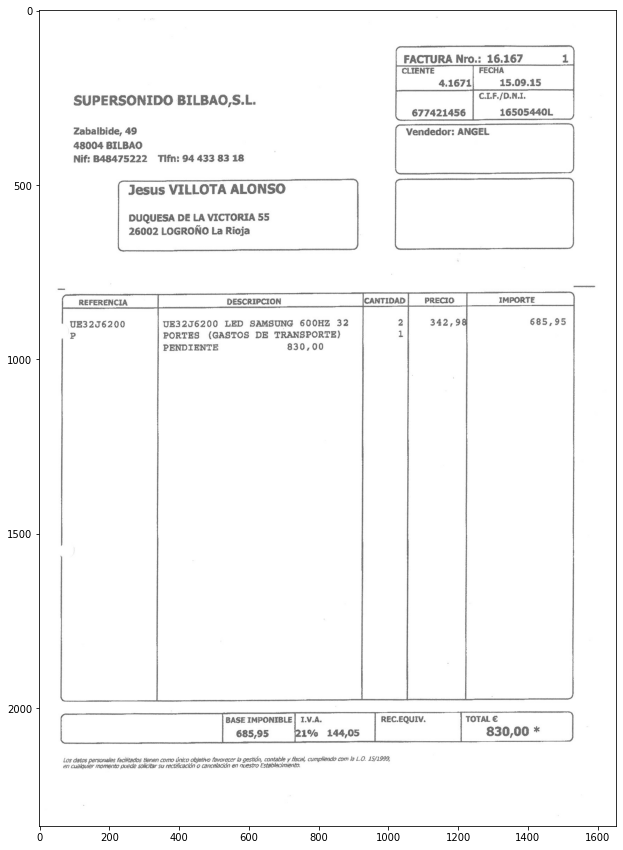

ID  |     TEXTO
-----------------------
3   |  DUQUESA DE LA VICTORIA 55 26002 LOGRONO La Rioja
5   |  UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00
20  |  C.LF./D.N.I.
22  |  UE3276200
25  |  830,00
26  |  15.09.15
27  |  830,00 *
28  |  4.1671
29  |  16505440L
30  |  677421456
31  |  685,95
32  |  
33  |  
34  |  
35  |  342,98
36  |  
37  |  21% 144,05
38  |  FACTURA Nro.: 16.167
39  |  685,95
40  |  Vendedor: ANGEL
41  |  Zabalbide, 49 48004 BILBAO
42  |  B48475222
43  |  Tifn: 94 433 83 18


In [ ]:
respuestas('Facturas/01.jpg',doc1)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


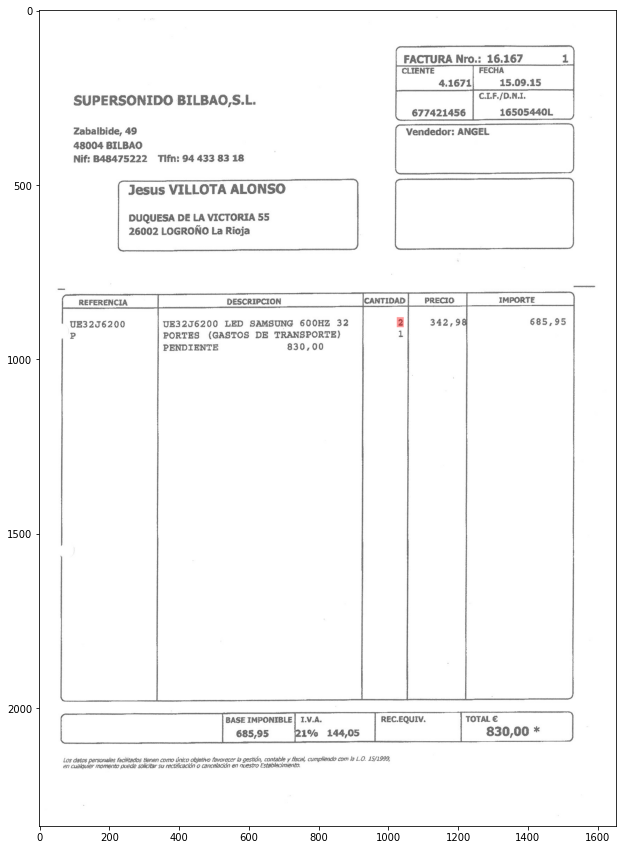

CANDIDATAS A PREGUNTA: 


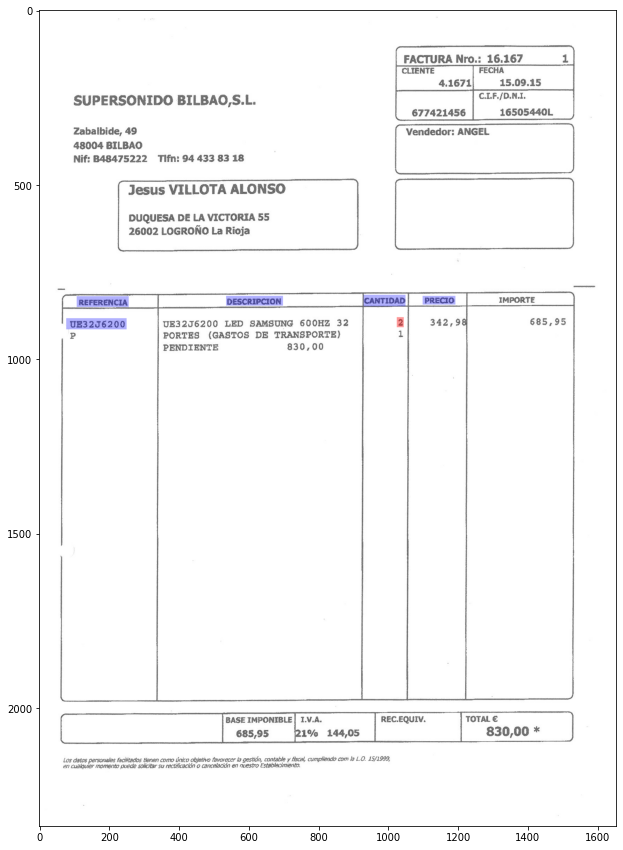



PARES CLAVE - VALOR: 
CANTIDAD
PRECIO
DESCRIPCION
REFERENCIA
UE3276200


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


['CANTIDAD', 'PRECIO', 'DESCRIPCION', 'REFERENCIA', 'UE3276200']






          text  prediction
0     CANTIDAD           0
1       PRECIO           0
2  DESCRIPCION           0
3   REFERENCIA           0
4    UE3276200           0

-------------------------------------------
APLICANDO LAS REGLAS: 
          text  prediction
0     CANTIDAD           1
1       PRECIO           0
2  DESCRIPCION           0
3   REFERENCIA           0
4    UE3276200           0


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,32)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


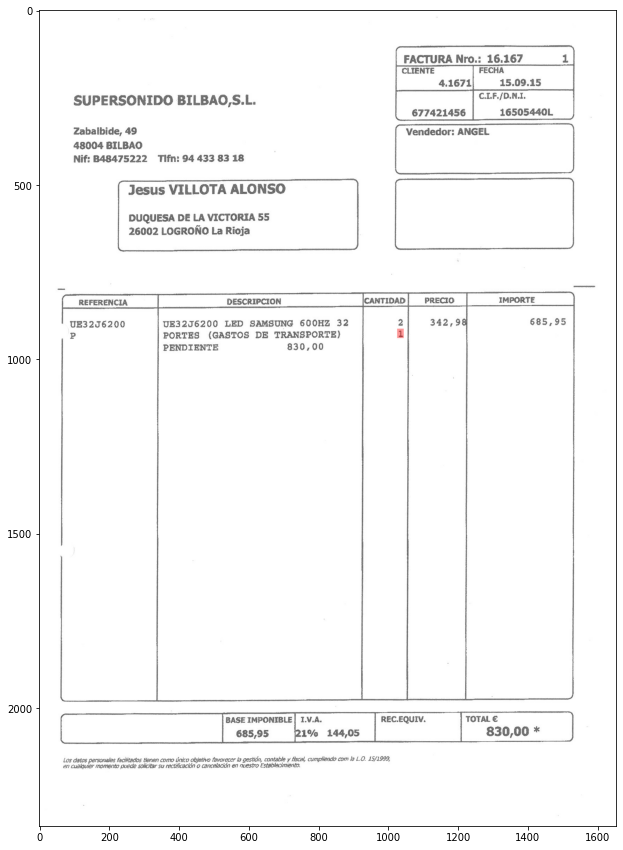

CANDIDATAS A PREGUNTA: 


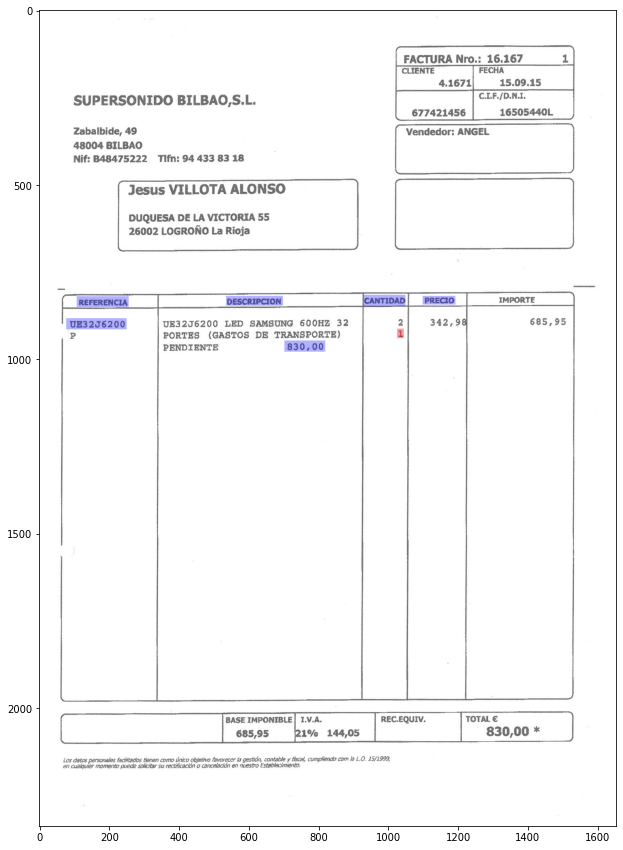



PARES CLAVE - VALOR: 
CANTIDAD
PRECIO
830,00
DESCRIPCION
REFERENCIA
UE3276200


***** Running Prediction *****
  Num examples = 6
  Batch size = 8


['CANTIDAD', 'PRECIO', '830,00', 'DESCRIPCION', 'REFERENCIA', 'UE3276200']






          text  prediction
0     CANTIDAD           0
1       PRECIO           0
2       830,00           0
3  DESCRIPCION           0
4   REFERENCIA           0
5    UE3276200           0

-------------------------------------------
APLICANDO LAS REGLAS: 
          text  prediction
0     CANTIDAD           1
1       PRECIO           0
2       830,00           0
3  DESCRIPCION           0
4   REFERENCIA           0
5    UE3276200           0


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,33)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


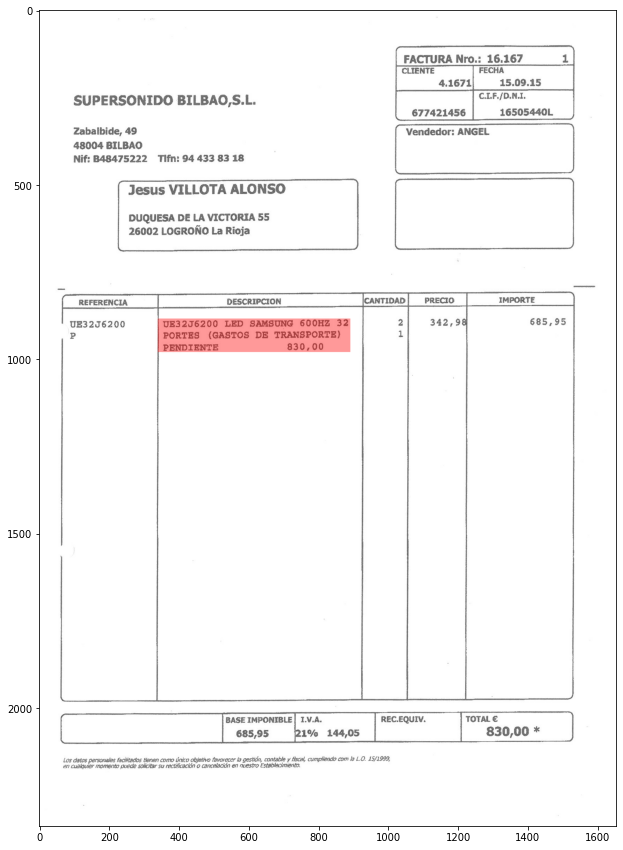

CANDIDATAS A PREGUNTA: 


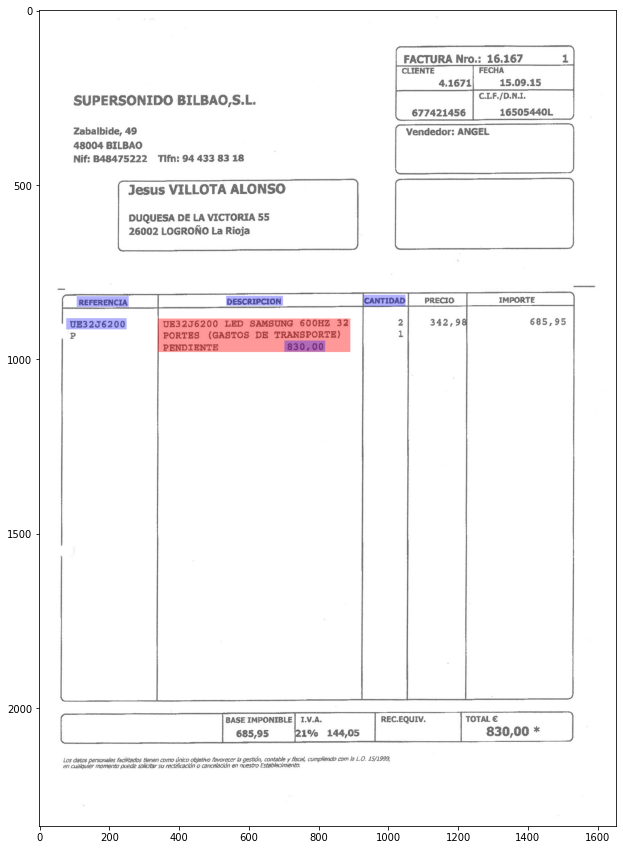



PARES CLAVE - VALOR: 
UE3276200 UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00
REFERENCIA UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00
DESCRIPCION UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00
830,00 UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00
CANTIDAD UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00


***** Running Prediction *****
  Num examples = 5
  Batch size = 8


['UE3276200 UE3236200 LED SAMSUNG 600HZ 32 PORT (TRANSPORTATION COSTS) PENDING 830.00', 'REFERENCE UE3236200 LED SAMSUNG 600HZ 32 PORTS (TRANSPORTATION COSTS) PENDING 830.00', 'DESCRIPTION UE3236200 LED SAMSUNG 600HZ 32 PORTS (TRANSPORTATION COSTS) PENDING 830.00', '830.00 UE3236200 LED SAMSUNG 600HZ 32 PORTS (TRANSPORTATION COSTS) PENDING 830.00', 'QUANTITY UE3236200 LED SAMSUNG 600HZ 32 PORTS (TRANSPORTATION COSTS) PENDING 830,00']






                                                text  prediction
0  UE3276200 UE3236200 LED SAMSUNG 600HZ 32 PORTE...           0
1  REFERENCIA UE3236200 LED SAMSUNG 600HZ 32 PORT...           0
2  DESCRIPCION UE3236200 LED SAMSUNG 600HZ 32 POR...           1
3  830,00 UE3236200 LED SAMSUNG 600HZ 32 PORTES (...           0
4  CANTIDAD UE3236200 LED SAMSUNG 600HZ 32 PORTES...           0

-------------------------------------------
APLICANDO LAS REGLAS: 
                                                text  prediction
0  UE3276200 UE3236200 LED SAMSUNG 600HZ 32 PORTE...           0
1  REFERENCIA UE3236200 LED SAMSUNG 600HZ 32 PORT...           0
2  DESCRIPCION UE3236200 LED SAMSUNG 600HZ 32 POR...           1
3  830,00 UE3236200 LED SAMSUNG 600HZ 32 PORTES (...           0
4  CANTIDAD UE3236200 LED SAMSUNG 600HZ 32 PORTES...           0


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,5)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


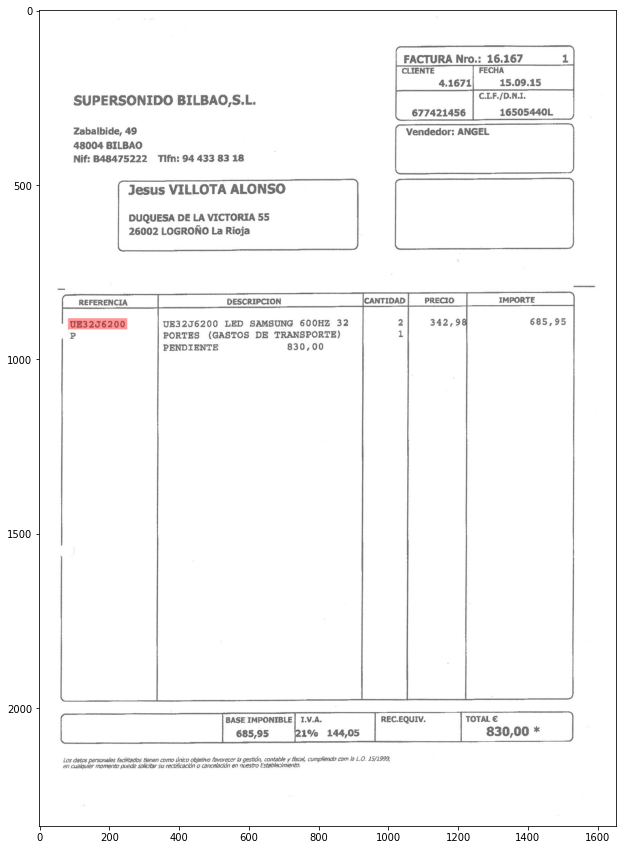

CANDIDATAS A PREGUNTA: 


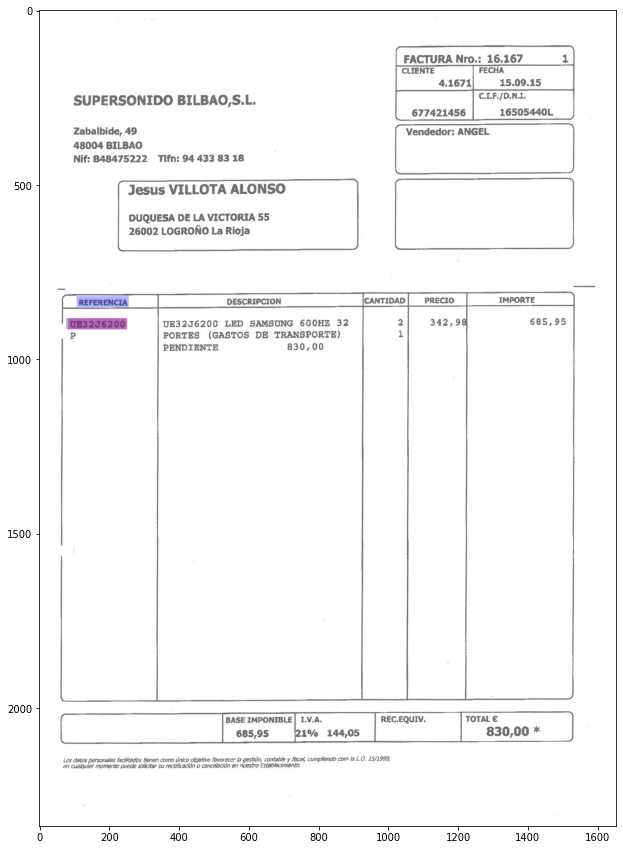

***** Running Prediction *****
  Num examples = 2
  Batch size = 8




PARES CLAVE - VALOR: 
UE3276200 UE3276200
REFERENCIA UE3276200
['UE3276200 UE3276200', 'REFERENCE UE3276200']






                   text  prediction
0   UE3276200 UE3276200           0
1  REFERENCIA UE3276200           1

-------------------------------------------
APLICANDO LAS REGLAS: 
                   text  prediction
0   UE3276200 UE3276200           0
1  REFERENCIA UE3276200           1


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,22)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


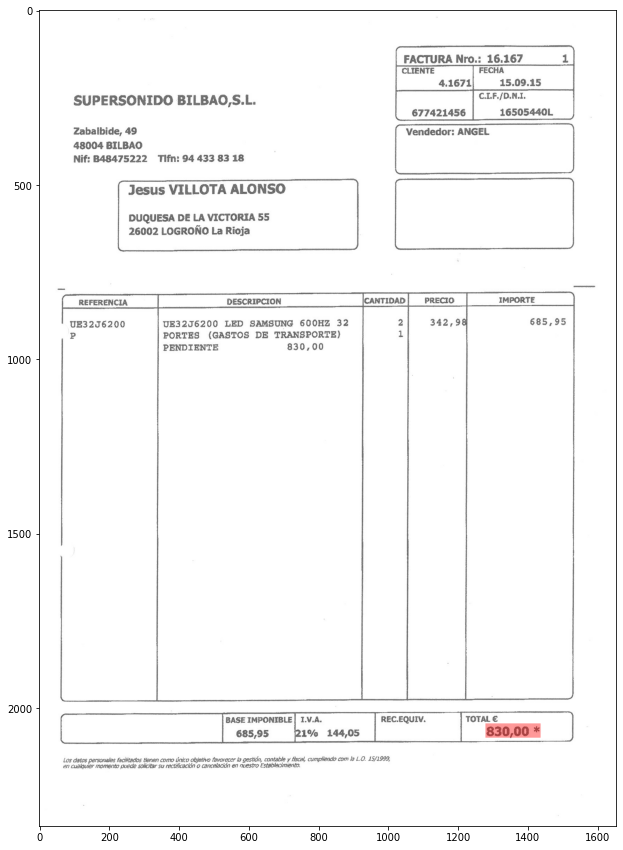

CANDIDATAS A PREGUNTA: 


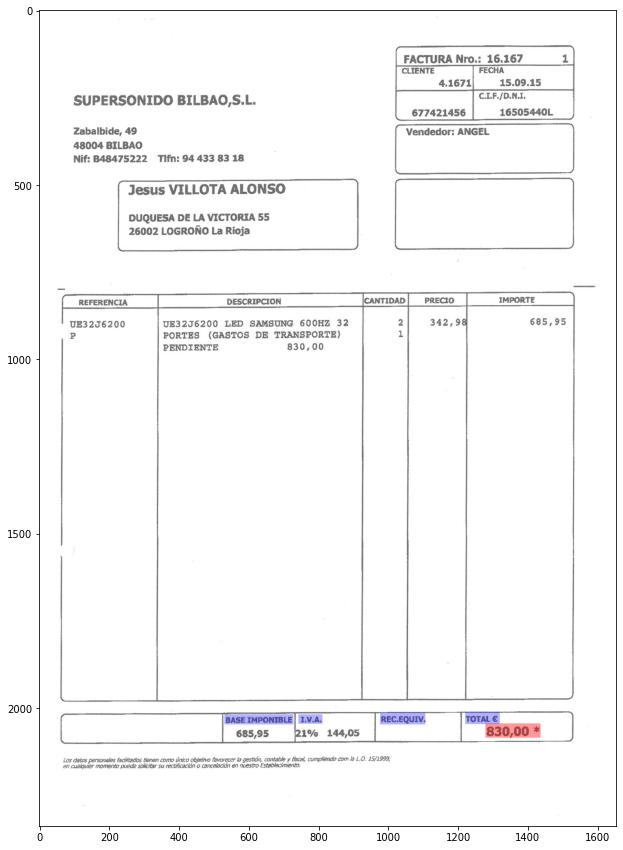



PARES CLAVE - VALOR: 
TOTAL € 830,00 *
REC.EQUIV. 830,00 *
LV.A, 830,00 *
BASE IMPONIBLE 830,00 *


***** Running Prediction *****
  Num examples = 4
  Batch size = 8


['TOTAL € 830,00 *', 'REC.EQUIV. 830.00 *', 'LV.A, 830.00 *', 'TAX BASE 830.00 *']






                      text  prediction
0         TOTAL € 830,00 *           0
1      REC.EQUIV. 830,00 *           0
2           LV.A, 830,00 *           0
3  BASE IMPONIBLE 830,00 *           0

-------------------------------------------
APLICANDO LAS REGLAS: 
                      text  prediction
0         TOTAL € 830,00 *           1
1      REC.EQUIV. 830,00 *           0
2           LV.A, 830,00 *           0
3  BASE IMPONIBLE 830,00 *           0


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,27)

FORMULARIO: 
MOSTRAMOS LA RESPUESTA SELECCIONADA: 


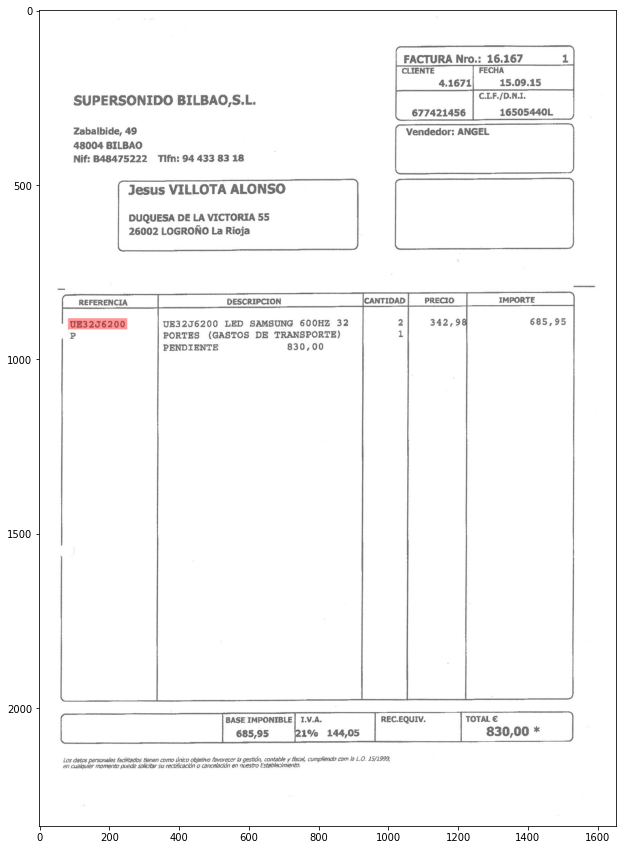

CANDIDATAS A PREGUNTA: 


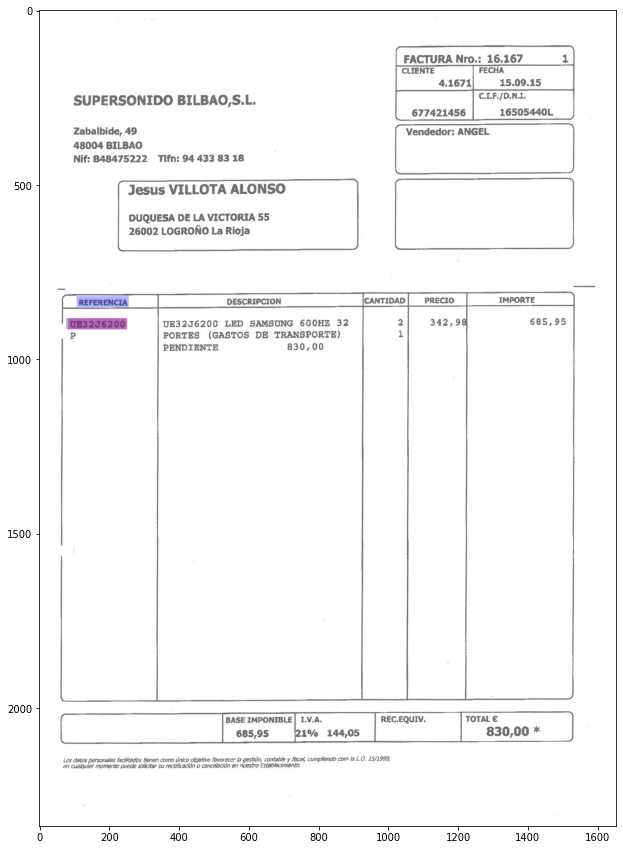

***** Running Prediction *****
  Num examples = 2
  Batch size = 8




PARES CLAVE - VALOR: 
UE3276200 UE3276200
REFERENCIA UE3276200
['UE3276200 UE3276200', 'REFERENCE UE3276200']






                   text  prediction
0   UE3276200 UE3276200           0
1  REFERENCIA UE3276200           1

-------------------------------------------
APLICANDO LAS REGLAS: 
                   text  prediction
0   UE3276200 UE3276200           0
1  REFERENCIA UE3276200           1


In [ ]:
encuentraPregunta('Facturas/01.jpg',doc1,22)

# Sacamos ahora todos los pares 

In [ ]:
def clave_valor(file,doc):
  img=cv2.imread(file)
  mostrarImagen(file)
  overlay = img.copy()
  cand,text=orden(file,doc)
  claveValor=[]
  for obj in doc[file][0]: #para cada respuesta 
    id,[xmin,ymin,xmax,ymax]=obj
    preguntas=cand[id]  #sacamos sus candidatos
    pregunta_respuesta=[]
    for q in preguntas:
      cadena=text[str(q)]+ ' ' +text[str(id)]
      cadena=' '.join(cadena.split())
      pregunta_respuesta.append(cadena)
    translator = Translator()
    translation=translator.translate(pregunta_respuesta, dest="en", src="es")
    TEXTO=[]
    for x in translation:
      TEXTO.append(x.text)
    dataEJ = Dataset(TEXTO,tokenizer)
    prediction=trainer.predict(dataEJ)[0].argmax(-1)
    d = {'text': pregunta_respuesta, 'prediction': predict(prediction)}
    df = pd.DataFrame(data=d)
    try:
      claveValor.append(d['text'][np.where(d['prediction']==1)[0][0]])
    except:
      pass
  return claveValor

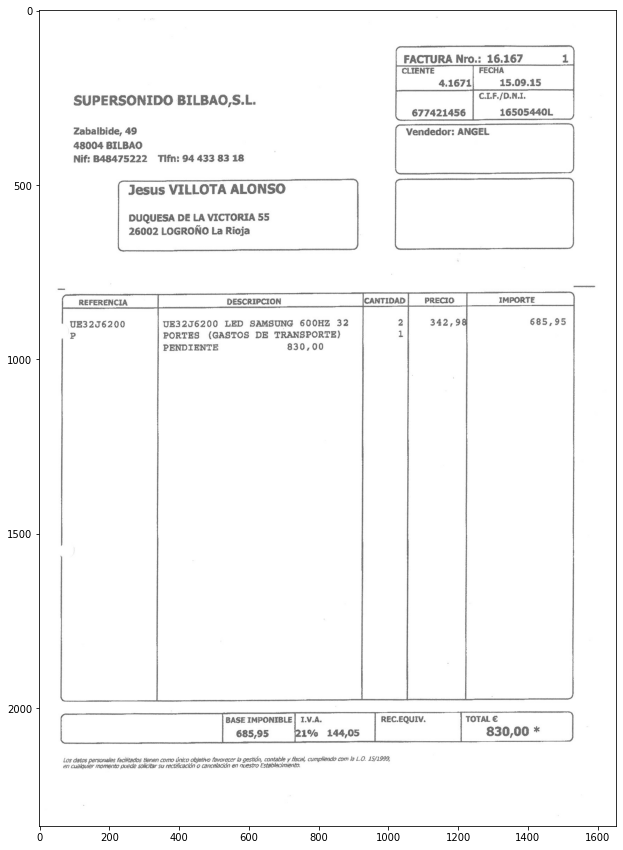

***** Running Prediction *****
  Num examples = 2
  Batch size = 8


***** Running Prediction *****
  Num examples = 5
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
***** Running Prediction *****
  Num examples = 5
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
***** Running Prediction *****
  Num examples = 5
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size

In [ ]:
KV=clave_valor('Facturas/01.jpg',doc1)

In [ ]:
KV

['Nif: DUQUESA DE LA VICTORIA 55 26002 LOGRONO La Rioja',
 'DESCRIPCION UE3236200 LED SAMSUNG 600HZ 32 PORTES (GASTOS DE TRANSPORTE) PENDIENTE 830,00',
 'C.LF./D.N.I. C.LF./D.N.I.',
 'REFERENCIA UE3276200',
 '830,00 830,00',
 'FECHA 15.09.15',
 'TOTAL € 830,00 *',
 'FECHA 4.1671',
 'C.LF./D.N.I. 16505440L',
 'CLIENTE 677421456',
 'BASE IMPONIBLE 685,95',
 'REFERENCIA',
 'REFERENCIA',
 'FECHA',
 'PRECIO 342,98',
 'REFERENCIA',
 'BASE IMPONIBLE 21% 144,05',
 'CLIENTE FACTURA Nro.: 16.167',
 'IMPORTE 685,95',
 'CLIENTE Vendedor: ANGEL',
 'Nif: Zabalbide, 49 48004 BILBAO',
 'Nif: B48475222',
 'Nif: Tifn: 94 433 83 18']

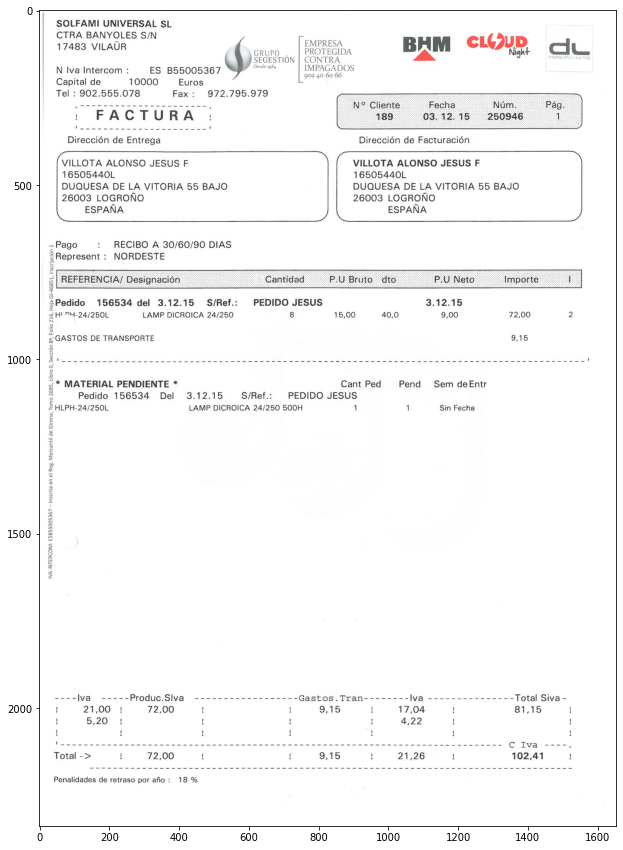

***** Running Prediction *****
  Num examples = 5
  Batch size = 8


***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 8
  Batch size = 8
***** Running Prediction *****
  Num examples = 5
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
***** Running Prediction *****
  Num examples = 8
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 5
  Batch size

In [ ]:
KV_1=clave_valor('Facturas/02.jpg',doc1)

In [ ]:
KV_1

['189 189',
 '',
 'dto 3.12.15',
 'REFERENCIA/ Designacis: REFERENCIA/ Designaciér',
 'ESPANA ESPANA',
 'Total -> 72,00',
 '3.12.15 9,00',
 'Gastos.Tran 17,04',
 'fUUUL.OIVe 72,00 21,00',
 '3.12.15 9,15',
 'Tel FACTURA',
 '3.12.15 72,00',
 '9,15',
 'Represent : RECIBO A 30/60/90 DIAS',
 'Gastos.Tran 4,22',
 'PEDIDO JESUS 15,00',
 '21,26',
 'dto 40,0',
 '189 16505440L DUQUESA DE LA VITORIA 55 BAJO 26003 LOGRONO ESPANA',
 'MATERIAL PENDIENTE * Pedido 156534 Del lva',
 'Tel 902.555.078',
 'Produc.Slva -lva',
 'fUUUL.OIVe 72,00 5,20',
 '189 03',
 'fUUUL.OIVe 72,00',
 'Represent : NORDESTE',
 'REFERENCIA/ Designacis: \\MP DICROICA 24/250',
 'N Iva Intercom : ES B55005367',
 'Gastos.Tran',
 'Gastos.Tran',
 'Total ->',
 '16505440L DUQUESA DE LA VITORIA 55 BAJO',
 'REFERENCIA/ Designacis: Neto Importe',
 '189',
 '17483 VILAUR',
 '17483 VILAUR cit']

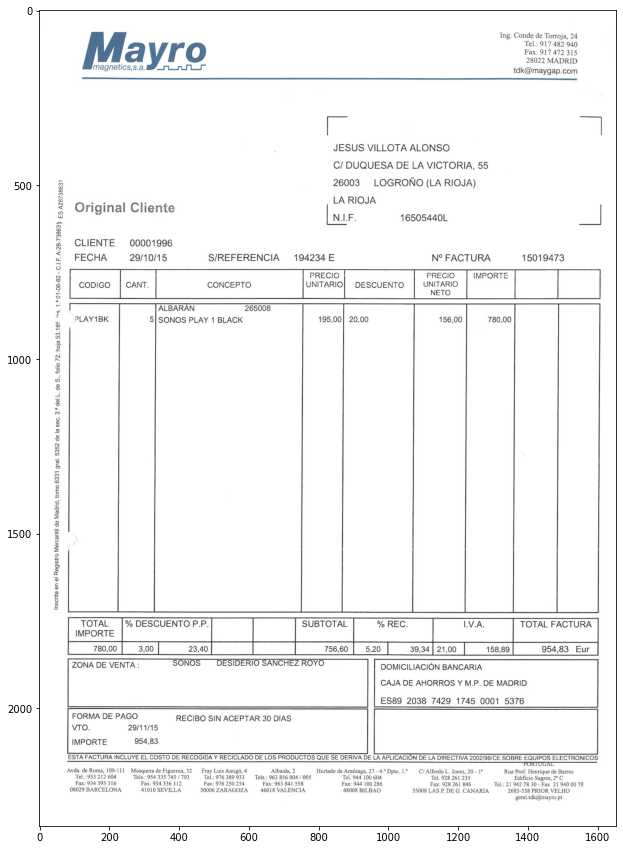

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


***** Running Prediction *****
  Num examples = 11
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 5
  Batch size = 8
***** Running Prediction *****
  Num examples = 4
  Batch size = 8
***** Running Prediction *****
  Num examples = 8
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
***** Running Prediction *****
  Num examples = 7
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch size = 8
***** Running Prediction *****
  Num examples = 2
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 3
  Batch siz

ValueError: ignored

In [ ]:
KV_1=clave_valor('Facturas/04.jpg',doc1)